In [86]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

import ecef_geodetic

import sys
sys.path.append('../../SAMI3-GITM-python')
import SAMI3_ESMF_Regrid


In [87]:
fnames = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf'
         ]

## Read in data

In [88]:
# Same as old Prasoon code - maybe could be changed? Works fine though
# Modification marked below:

grace = [] # list of Xarray DataSets from each day

for f in tqdm(fnames): # Probably don't need a progress bar here. only takes ~15 seconds
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = pd.Timestamp(f.split('_')[-2])  # Aaron changed how date_0 was calculated.
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print('Columns in Satellite Data: \n', data.data_vars, 
      '\n Start & end dates:', data.date.min().values, data.date.max().values)

100%|█████████████████████████████████████████████| 3/3 [00:16<00:00,  5.45s/it]

Columns in Satellite Data: 
 Data variables:
    Timestamp          (step) float64 438kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 438kB -59.12 -59.12 -59.77 ... 24.74 24.74
    Longitude          (step) float64 438kB -175.2 -175.2 -175.2 ... 2.673 2.673
    Radius             (step) float64 438kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 438kB 1.975e+06 -3.314e+06 ... 2.534e+07
    GPS_Position_Y     (step) float64 438kB -1.886e+07 -2.172e+07 ... -7.897e+06
    GPS_Position_Z     (step) float64 438kB -1.894e+07 -1.513e+07 ... 3.192e+06
    LEO_Position_X     (step) float64 438kB -3.49e+06 -3.49e+06 ... 6.189e+06
    LEO_Position_Y     (step) float64 438kB -2.959e+05 -2.959e+05 ... 2.89e+05
    LEO_Position_Z     (step) float64 438kB -5.858e+06 -5.858e+06 ... 2.855e+06
    PRN                (step) uint16 109kB 11 32 11 32 11 32 ... 21 25 29 30 31
    L1                 (step) float64 438kB 2.347e+07 2.351e+07 ... 2.074e+07
  

In [89]:
# Data is flat - convert it to a Pandas DataFrame. 
# They're easier to work with and writing csv files is built-in.

# Concat the list of xr Datasets, converting each to Pandas as we go
df0 = pd.concat([i.to_pandas() for i in grace]).sort_values('date')

# Only select columns I care about - drop the index too 
df = df0[['Timestamp', 'GPS_Position_X', 
       'GPS_Position_Y', 'GPS_Position_Z', 'LEO_Position_X', 'LEO_Position_Y',
       'LEO_Position_Z', 'PRN', 'Latitude', 'Longitude',
       'Absolute_STEC', 'Elevation_Angle', 'date', 'LT']].reset_index(drop=True)

## Mask off data we don't want

This should be easy to change if other data is required

The variable `df` is kept so the code after selecting data is generalizable. 

There is some debug info printed & plotted. None of that is necessary... I'm leaving it in for proofthat the code is working as expected. The cells can be deleted. I would have but wanted to show Prasoon what's happening

In [5]:
# Only keep data on the 17th

# Probably needs to also include a condition on elevation angle...

In [90]:
df = df.iloc[np.where((df.date > pd.Timestamp('20130317'))
                    & (df.date < pd.Timestamp('20130318')))].reset_index(drop=True)

In [91]:
# Just check to make sure things look right - can delete this cell. not needed
df.columns, df.PRN.unique(), df.date.min(), df.date.max()

(Index(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z',
        'LEO_Position_X', 'LEO_Position_Y', 'LEO_Position_Z', 'PRN', 'Latitude',
        'Longitude', 'Absolute_STEC', 'Elevation_Angle', 'date', 'LT'],
       dtype='object'),
 array([11, 12, 14, 18, 25, 31, 21, 30,  6, 16, 29,  3,  5, 13,  7, 10, 26,
         2,  8,  4,  9, 28, 17, 20, 32, 22, 19, 15, 23], dtype=uint16),
 Timestamp('2013-03-17 00:00:09'),
 Timestamp('2013-03-17 23:59:59'))

### Select one orbit

Since this is just me debgging, I'm going to filter by day AND only take one of those orbits. 

In [92]:
# Find where absolute value of df.Latitude is highest
# Returns peaks & their values. don't care about values, store it as a `_` and forget about it.
peaks, _ = find_peaks(df.Latitude.abs())
print(len(peaks))

30


In [93]:
# Function for rays along Line of sight from Grace to GPS satellite

def line_of_sight_calc(start, end, #start and end pts
                       num_points=50, # number of points 
                       base = 4, # Adjust base of log to get required point density
                       spacing='log'): # currently supports log & linear
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    if spacing == 'log':
        # see below for a discussion on why I did this
        deltas = np.geomspace(0.00001, 1, num=num_points) ** (base/10)
    
    elif spacing == 'linear':
        deltas = np.linspace(0, 1, num=num_points)
        
    else:
        raise ValueError
    
    # Scale and translate values to fit the line segment
    points = [start + t * direction for t in deltas]

    return points

In [95]:
orbits =  list(range(23,28))

for orbit_num in tqdm(orbits):
    # Storing indices for given orbit
    peaks, _ = find_peaks(df.Latitude.abs())
    peaks = peaks[orbit_num:orbit_num+2]

    df1 = df.iloc[peaks[0]:peaks[1]].reset_index(drop=True)

    # Generating cartesian points along the ray of Line of sight
    cartesian_points = []
        
    for _, row in df1.iterrows(): # Returns index, row... don't care about index
        
        grace_cart_loc = [row['LEO_Position_X'],
                          row['LEO_Position_Y'],
                          row['LEO_Position_Z']]
    
        gps_cart_loc = [row['GPS_Position_X'],
                        row['GPS_Position_Y'],
                        row['GPS_Position_Z']]
        
        # Compute ray - this is a (N_points, 3) shaped array
        a_ray = line_of_sight_calc(grace_cart_loc, gps_cart_loc)
        
        # Convert back to lat/lon/alt - ecef conversions need x,y,z & can't be vectorized
        a_ray_sph = [] # Same shape as a_ray
        for pt in a_ray:
            a_ray_sph.append(ecef_geodetic.ecef_to_lla(*pt))
            
        cartesian_points.append(a_ray_sph)
    
    cartesian_points = np.array(cartesian_points) # easier to slice from than list

    # Converting output to dataframe
    df_raypaths = pd.DataFrame()
    df_raypaths['lat'] = cartesian_points[:,:,0].flatten()
    df_raypaths['lon'] = cartesian_points[:,:,1].flatten()
    df_raypaths['alt'] = cartesian_points[:,:,2].flatten() / 1000

    path = '/home/pxv220016/scratch/'
    csv_name = path + 'multiorbit_data/single_orbit_los_' + str(orbit_num) + '.csv'
    csv_raw_name = path + 'multiorbit_data/single_orbit_raw_' + str(orbit_num) + '.csv'
    df_raypaths.to_csv(csv_name, index=False)
    df1.to_csv(csv_raw_name, index=False)

    file_name = path + 'multiorbit_data/orbit_' + str(orbit_num)
    
    SAMI3_ESMF_Regrid.main(sami_data_path='/home/pxv220016/scratch/2013-03-17_SAMI', 
                           dtime_sim_start='20130316',
                           cols='edens',
                           out_dir='/home/pxv220016/scratch/multiorbit_data',
                           custom_input_file=csv_name,
                           ESMF_DIR='/home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/',
                           remake_files=True,
                           output_filename=file_name,
                             )
    
    print('DONE...', orbit_num)
    
    

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not contain satell

 20%|████████▊                                   | 1/5 [03:45<15:02, 225.59s/it]

DONE... 23
Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not con

 40%|█████████████████▌                          | 2/5 [08:25<12:52, 257.51s/it]

DONE... 24
Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not con

 60%|██████████████████████████▍                 | 3/5 [12:09<08:04, 242.31s/it]

DONE... 25
Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not con

 80%|███████████████████████████████████▏        | 4/5 [16:22<04:06, 246.50s/it]

DONE... 26
Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not con

100%|████████████████████████████████████████████| 5/5 [20:34<00:00, 246.87s/it]

DONE... 27


# Orbit Analysis - Lats in x-coord - Method 1

In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.interpolate import make_interp_spline, CubicSpline
from scipy.signal import savgol_filter, butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt

from tqdm import tqdm
import importlib as il
import ecef_geodetic
import datetime as dt

from utility_programs import filters


In [21]:
def filt_filt(da,
              freq=5,
              lims=[40, 85],
              order=1,
              percent=True):

    # Define sampling frequency and limits in minutes
    lower_limit = min(lims)
    upper_limit = max(lims)

    # Convert limits to corresponding indices
    # lower_index = int(lower_limit / freq)
    # upper_index = int(upper_limit / freq)

    # Design the bandpass filter
    nyquist_freq = 0.5 * freq
    lower_cutoff = (1/lower_limit) / nyquist_freq
    upper_cutoff = (1/upper_limit) / nyquist_freq
    b, a = butter(order, [upper_cutoff, lower_cutoff],
                         btype='band', analog=False)

    # Apply the filter to the data
    filtd = filtfilt(b, a, da, axis=0)
    # filtd = xr.apply_ufunc(filtfilt, b, a, da, dask='allowed')

    if percent:
        return (100 * (filtd) / da)

    else:
        if isinstance(da, np.ndarray):
            return filtd
        else:
            da.values = filtd
            return da

Process ForkPoolWorker-81:
Traceback (most recent call last):
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
MemoryError


In [22]:
def vtec_cal(los_ds, sami_time, h=2400):

    # getting tecs through integration without altitude condition
    
    if h is None:
        tecs = np.trapz(los_ds.sel(sami_time=sami_time, method='nearest').edens.values,
                       los_ds.alt.values,
                       axis=1) /1e7

    else:
        # calculating slant TEC by putting condition on upper height
        tecs = []
        
        for p in los_ds.sat_pt:
            
            alt_all = los_ds.alt.sel(sat_pt=p).values
            eden_all = los_ds.sel(sami_time=sami_time, sat_pt = p, method='nearest').edens.values
            alt_h = []
            edens_h = []
            
            for i in range(len(alt_all)):
                if alt_all[i] <= h:
                    # change 2400 to adjust the limit on height
                    # 2400 is height till which gloabl_SAMI has obtained the data
                    alt_h.append(alt_all[i])
                    edens_h.append(eden_all[i])
        
            t = np.trapz(edens_h, alt_h)/1e7
            tecs.append(t)
    
    return tecs

In [23]:
def los_tec(path, orbit_num):

    # initializing data and obtaining stec value and storing them in datasets
    
    # reading data from .nc (contains interpolated edens values at 
    # the grid points that we provided in csv) and csv orbit files 
    file_path = path + 'orbit_' + str(orbit_num) + '_SAMI-REGRID.nc'
    los_ds = xr.open_dataset(file_path)
    csv_file = path + 'single_orbit_raw_' + str(orbit_num) + '.csv'
    df_grace = pd.read_csv(csv_file)
    n = len(df_grace)

    # Finding the sami_time at the mid of the orbit
    d = [pd.Timestamp(i) for i in df_grace.date]
    ref_date = dt.datetime(2013,1,1)
    sami_time = ref_date + sum([i - ref_date for i in d], dt.timedelta())/len(df_grace.date) # average of time of satellite pass
    
    # Storing data in los_ds and reshaping it for easy integration
    los_ds['sat_pt'] = ('sat_pt'), df_grace.index
    los_ds['alt_lev'] = ('alt_lev'), list(range(50))
    los_ds['lat'] = ('sat_pt','alt_lev'), los_ds.lat.values.reshape(n,50)
    los_ds['lon'] = ('sat_pt','alt_lev'), los_ds.lon.values.reshape(n,50)
    los_ds['alt'] = ('sat_pt','alt_lev'), los_ds.alt.values.reshape(n,50)
    los_ds['edens'] = ('sami_time', 'sat_pt','alt_lev'), los_ds.edens.values.reshape(596,n,50)

    df_grace['tecs'] = vtec_cal(los_ds, sami_time, h=2400)

    # Finding longitude at the center of sat-pass
    lon_mean = (los_ds.sel(alt_lev=0, sat_pt=1732/2)).lon.values
    if lon_mean < 0:
        lon_mean += 360

    return los_ds, df_grace, sami_time, lon_mean
    

In [24]:
print(np.linspace(3,10,8))
print(list(range(3,10)))
print(5%2, 5/2, 5//2)

[ 3.  4.  5.  6.  7.  8.  9. 10.]
[3, 4, 5, 6, 7, 8, 9]
1 2.5 2


In [26]:
def calc_stec_vtec(df_grace, elev_mask):
    
    lats = df_grace.Latitude[elev_mask].unique()
    
    stec_t = []
    vtec_t = []
    for l in lats:
        df_lat = (df_grace.iloc[np.where(df_grace.Latitude == l)].reset_index(drop = True))
        num_s = 0
        denom_s = 0
        num_v = 0
        denom_v = 0
        
        for t, el in zip(df_lat.tecs, df_lat.Elevation_Angle):
            if el > 50:
                num_s += t*el
                denom_s += el
                num_v += t*np.sin(np.radians(el))
                denom_v += 1
        stec_t.append(num_s/denom_s)
        vtec_t.append(num_v/denom_v)

    nature = ' asc '
    if lats[0] > lats[-1]:
        nature = ' desc '
    
    stitched_ds = xr.Dataset()    
    stitched_ds['lats'] = ('lats'), lats
    stitched_ds['stec'] = ('lats'), stec_t
    stitched_ds['vtec'] = ('lats'), vtec_t
    
    return stitched_ds, nature
    

In [27]:
def smooth_stec(stitched_ds, limits=70):

    # Smoothening of curves
    stitched_ds_sort = stitched_ds.sortby('lats', ascending=True)
    latitudes = np.linspace(-limits, limits, 500, endpoint='True')
    b_spline_coeff_stec = make_interp_spline(stitched_ds_sort.lats, stitched_ds_sort.stec)
    stec_s = b_spline_coeff_stec(latitudes)

    return latitudes, stec_s


In [28]:
def apply_savgol(func, window=60, order=2, diff=False, dif_func=[]):
    fil_func = savgol_filter(func, window, order)
    
    if diff == True:
        if len(dif_func) == 0:
            dif_func = func
        dif = [i-j for i,j in zip(dif_func,fil_func)]
        return dif
        
    return fil_func        

100%|█████████████████████████████████████████████| 8/8 [03:01<00:00, 22.67s/it]


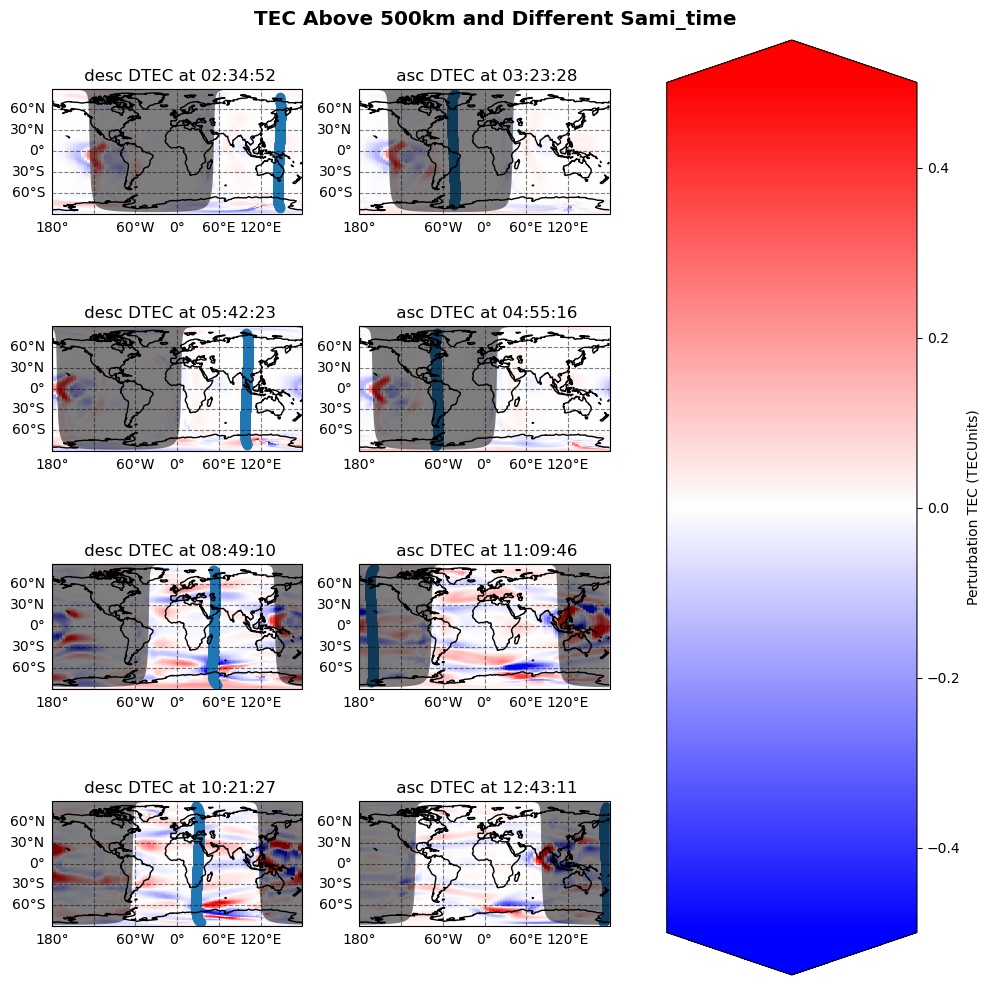

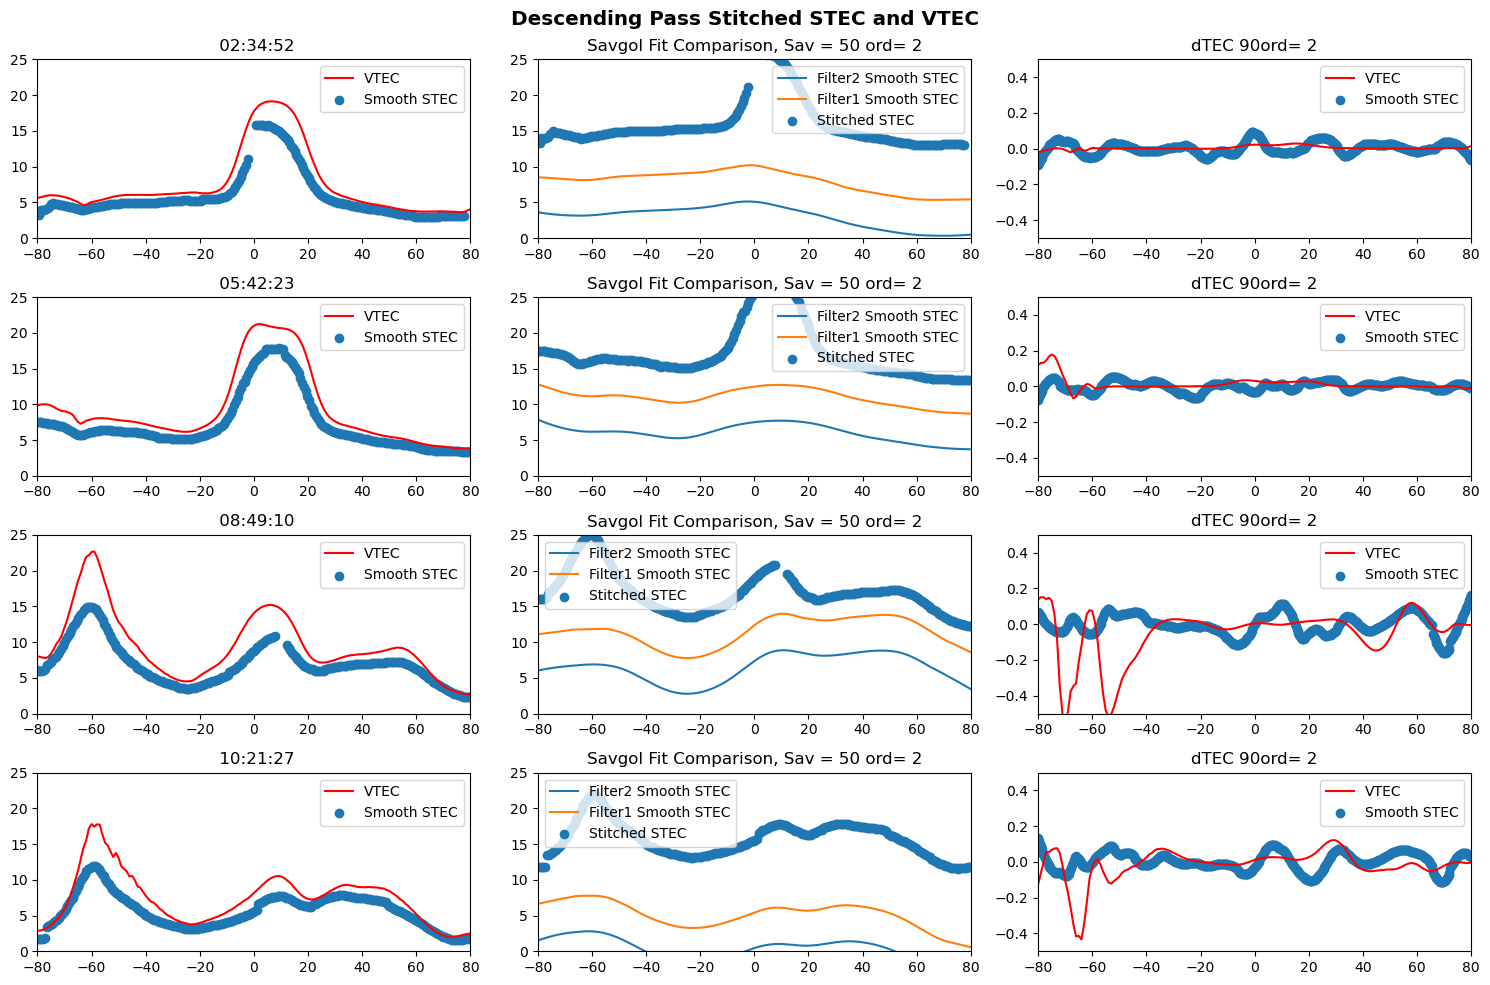

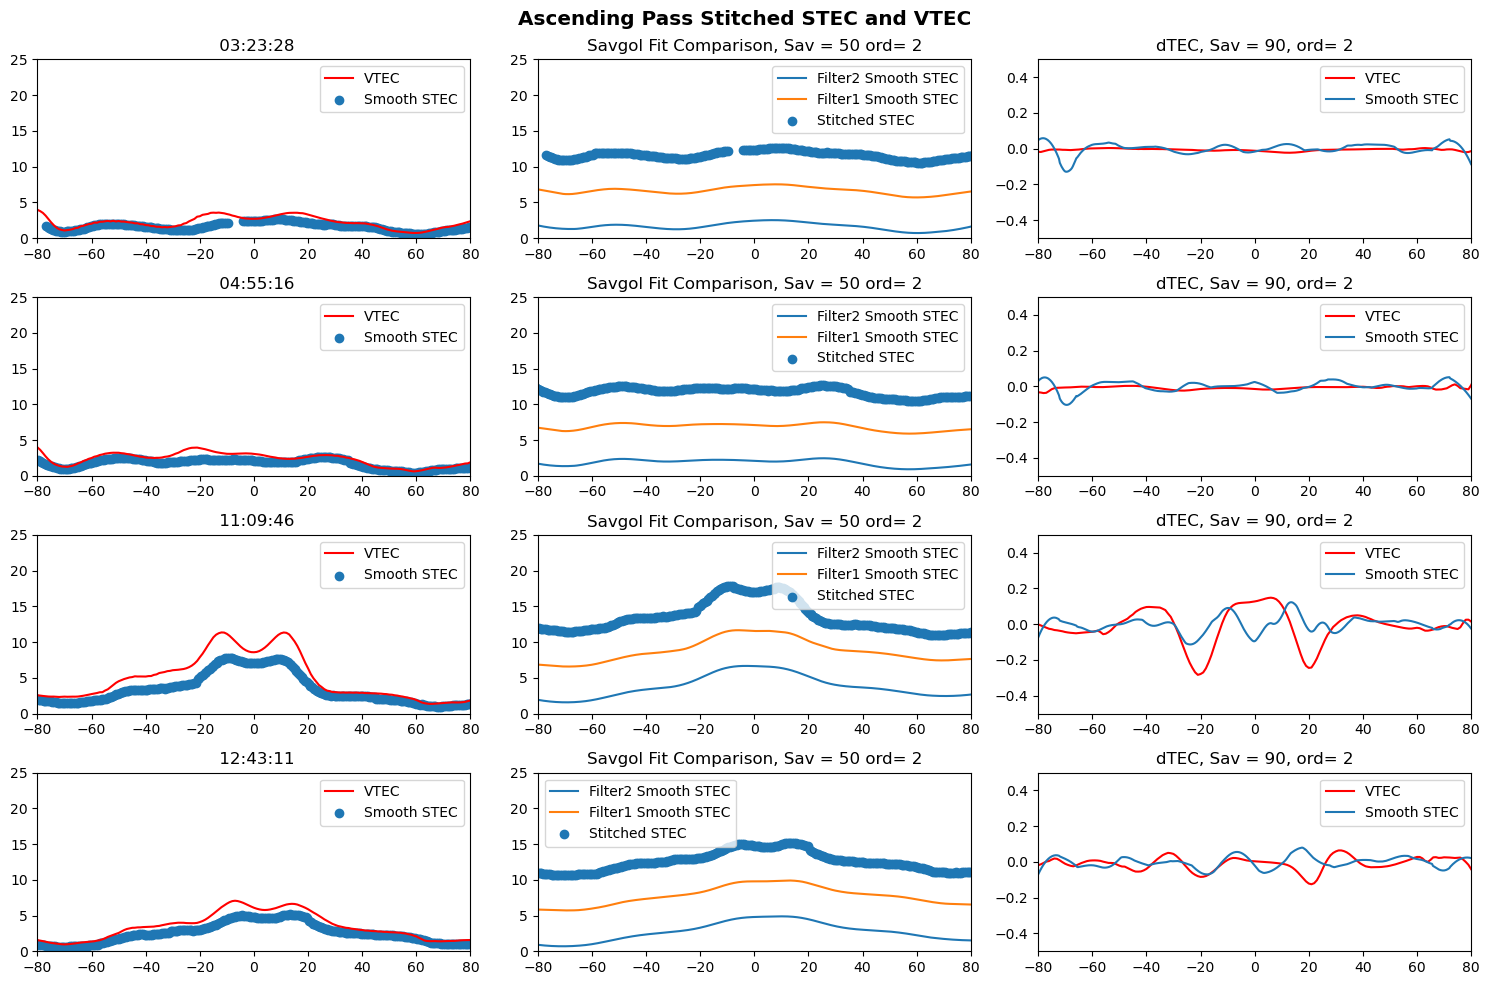

In [33]:
global_ds = xr.open_dataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/temp/GLOBAL_SAMI_REGRID_new.nc',
                               engine='h5netcdf')
# 10
orbits = [2,3,6,5,10,13,12,15] #list(range(2,10))#list(range(12))
path = '/home/pxv220016/scratch/multiorbit_data/' 


# Initialization of plots
a = 0
cmin = -0.5
cmax = 0.5
xmax = 80
xmin = -80
ymax = 25
ymin = 0

fig1 = plt.figure(figsize=(10,10))
specs = fig1.add_gridspec(4, 3, width_ratios=[1,1,1])
axes = []

fig_d = plt.figure(figsize=(15,10))
specs_d = fig_d.add_gridspec(4,3,width_ratios=[1,1,1])
axes_d = []

fig_a = plt.figure(figsize=(15,10))
specs_a = fig_a.add_gridspec(4,3,width_ratios=[1,1,1])
axes_a = []


for orbit_num in tqdm(orbits):
    orbit_num = int(orbit_num)
    los_ds, df_grace, sami_time, lon_mean = los_tec(path, orbit_num)

    # obtaining VTEC from the global SAMI
    grace_est_tec = global_ds.sel(time=sami_time, 
                                  method='nearest').edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7
    
    # Obtaining dTEC after applying [40,85] minute bandpass filter
    del_tec = filters.make_fits(global_ds.edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7, percent=False).sel(time=sami_time, 
                                  method='nearest')
    
    # putting condition on the elevation angle
    elev_mask = df_grace.Elevation_Angle > 50 

    # Stiching STEC and smoothening STEC and VTEC
    stitched_ds, nature = calc_stec_vtec(df_grace, elev_mask)
    lats_smooth, stec_smooth = smooth_stec(stitched_ds, xmax)

    
    # Removing the gaps created while stitching STEC
    shift = 0
    stec_no_gap = []
    for i in range(len(stec_smooth)-2):
        stec_no_gap.append(stec_smooth[i] - shift)
        if abs(stec_smooth[i+2] - stec_smooth[i]) > 0.25:
            shift += stec_smooth[i+1] - stec_smooth[i]
    stec_no_gap.append(stec_smooth[-2] - shift)        
    stec_no_gap.append(stec_smooth[-1] - shift)        
    
    
    sav_1 = 50
    sav_2 = 90
    #stec_sav1 = apply_savgol(stec_smooth, 10, 2)
    stec_sav2 = apply_savgol(stec_no_gap, sav_1, 1, diff=False)
    #stec_smooth_fin = filters.make_fits(stec_sav2, freq=1, lims=[5,400])
    #del_stec_smooth = [i-j for i,j in zip(stec_sav2, stec_smooth_fin)]
    del_stec_smooth = apply_savgol(stec_sav2, sav_2, 2, diff=True)
    stec_smooth_fin = apply_savgol(stec_sav2, sav_2, 2)

    
    # Plot will have VTEC in the background and STEC values at GRACE locations
    nature = ' asc '
    if df_grace.Latitude[0] > df_grace.Latitude[10]:
        nature = ' desc '
    

    # Plotting dTEC
    row = a//2
    col = a%2
    #print(row,col, a)

    # Plotting dTEC for all the ascending and descending passes
    axes.append(fig1.add_subplot(specs[row, col], projection=ccrs.PlateCarree()))
    c = del_tec.plot(x='lon', vmin = cmin, vmax = cmax, cmap='bwr', add_colorbar=False, ax=axes[-1])
    axes[-1].scatter(df_grace.Longitude[elev_mask], df_grace.Latitude[elev_mask])
    axes[-1].coastlines()
    axes[-1].add_feature(Nightshade(sami_time))
    axes[-1].gridlines(draw_labels=['bottom', 'left'], 
                       linestyle='--', color='k', alpha = 0.5)
    axes[-1].set_title(nature + 'DTEC at ' + str(sami_time)[11:19])
    
    if nature == ' desc ':
        # Plotting VTEC and stitched STEC
        axes_d.append(fig_d.add_subplot(specs[row, 0]))
        #axes_d[-1].scatter(stitched_ds.lats, stitched_ds.vtec, label='Smooth VTEC')
        axes_d[-1].plot(grace_est_tec.sel(lon=lon_mean, method='nearest').lat, grace_est_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_d[-1].scatter(stitched_ds.lats, stitched_ds.stec, label='Smooth STEC')
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_ylim(ymin, ymax)
        axes_d[-1].set_title(str(sami_time)[10:19])
        axes_d[-1].legend()

        axes_d.append(fig_d.add_subplot(specs[row, 1]))
        #axes_d[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_d[-1].plot(lats_smooth, stec_smooth_fin, label='Filter2 Smooth STEC')
        axes_d[-1].plot(lats_smooth, stec_sav2 + 5, label='Filter1 Smooth STEC')
        axes_d[-1].scatter(stitched_ds.lats, stitched_ds.stec + 10, label='Stitched STEC')
        axes_d[-1].set_ylim(ymin, ymax)
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_title('Savgol Fit Comparison, Sav = ' + str(sav_1) + ' ord= 2')
        axes_d[-1].legend()
        
        axes_d.append(fig_d.add_subplot(specs[row, 2]))
        #axes_d[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_d[-1].plot(del_tec.sel(lon=lon_mean, method='nearest').lat, del_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_d[-1].scatter(lats_smooth, del_stec_smooth, label='Smooth STEC')
        axes_d[-1].set_ylim(-0.5, 0.5)
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_title('dTEC ' + str(sav_2) + 'ord= 2')
        axes_d[-1].legend()
        
    else:
        # Plotting VTEC and stitched STEC
        axes_a.append(fig_a.add_subplot(specs[row, 0]))
        #axes_a[-1].scatter(stitched_ds.lats, stitched_ds.vtec, label='Smooth VTEC')
        axes_a[-1].plot(grace_est_tec.sel(lon=lon_mean, method='nearest').lat, grace_est_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_a[-1].scatter(stitched_ds.lats, stitched_ds.stec, label='Smooth STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(ymin, ymax)
        axes_a[-1].set_title(str(sami_time)[10:19])
        axes_a[-1].legend()
        
        axes_a.append(fig_a.add_subplot(specs[row, 1]))
        #axes_a[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_a[-1].plot(lats_smooth, stec_smooth_fin, label='Filter2 Smooth STEC')
        axes_a[-1].plot(lats_smooth, stec_sav2 + 5, label='Filter1 Smooth STEC')
        axes_a[-1].scatter(stitched_ds.lats, stitched_ds.stec + 10, label='Stitched STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(ymin, ymax)
        axes_a[-1].set_title('Savgol Fit Comparison, Sav = ' + str(sav_1) + ' ord= 2')
        axes_a[-1].legend()

        axes_a.append(fig_a.add_subplot(specs[row, 2]))
        #axes_a[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_a[-1].plot(del_tec.sel(lon=lon_mean, method='nearest').lat, del_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_a[-1].plot(lats_smooth, del_stec_smooth, label='Smooth STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(-0.5, 0.5)
        axes_a[-1].set_title('dTEC, Sav = ' + str(sav_2) + ', ord= 2')
        axes_a[-1].legend()
    

    
    a += 1

    
    # ------PLOTTING---------
    '''
    # Plotting satellite passes (with each gps satellite shown) on 
    # global map with VTEC in background

    n = int(len(df_grace.LT)/2)
    prn = df_grace.PRN[elev_mask].unique()
    shape = ['o', 's', '^', 'v', 'x', '+', '*', 'D']
        
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    grace_est_tec.plot(x='lon',cbar_kwargs={'label':'VTEC'})
    ax.coastlines()
    ax.add_feature(Nightshade(sami_time), alpha=0.3)
    
    ax.set_title('LT = ' + str(df_grace.LT[n])[:5] + ', UT = ' + str(df_grace.date[n]) + nature)
    
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        ecef_geodetic = il.reload(ecef_geodetic)
        lat, lon, _ = ecef_geodetic.ecef_to_lla(df_g1.GPS_Position_X[0],df_g1.GPS_Position_Y[0],df_g1.GPS_Position_Z[0])
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(lon, lat, marker = s, c='w')
        # each sub-intervals for different prn is offset by 5 longitudes to prevent overlapping
        plt.scatter(df_g1.Longitude[elev_mask1] + 5*i, df_g1.Latitude[elev_mask1], c=df_g1.tecs[elev_mask1], vmin = min(df_grace.tecs[elev_mask]), vmax = max(df_grace.tecs[elev_mask]), marker = s, transform=ccrs.PlateCarree(), label = p)     
    plt.legend()
    plt.colorbar();
    #plt.show()
    '''
    
    
    '''
    # Plotting STEC for each PRN (colorbar showing elevation angle)
    # and VTEC against Latitude
    
    plt.figure(figsize=(12,8))
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(df_g1.Latitude[elev_mask1], df_g1.tecs[elev_mask1], c=df_g1.Elevation_Angle[elev_mask1], vmin = min(df_grace.Elevation_Angle[elev_mask]), vmax=max(df_grace.Elevation_Angle[elev_mask]), marker =s, label = p)
    
    grace_est_tec.sel(lon=lon_mean, method='nearest').plot(color='red')
    plt.legend()
    plt.colorbar();
    #plt.show()
    '''


    '''
    # Plotting Smoothened STEC and VTEC (using spline first and savgol)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))    
    axs[0].scatter(stitched_ds.lats,stitched_ds.vtec, label='Stiched VTECs')
    axs[0].scatter(stitched_ds.lats,stitched_ds.stec, label='Stitched STECs')
    grace_est_tec.sel(lon=lon_mean, method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_title('Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stitched_ds.stec, stitched_ds.vtec)]
    axs[1].set_title('Difference Between Stitched STEC and VTEC')
    axs[1].scatter(stitched_ds.lats, del_t)
    axs[1].set_ylim(bottom = 0, top = 4)
    #plt.show()
    '''
    
    '''
    # Plotting Error Between Smoothened STEC and VTECs
    
    stec_smooth_err = [100*(j-i)/i for i,j in zip(stitched_ds.stec, stec_smooth)]
    vtec_smooth_err = [100*(j-i)/i for i,j in zip(stitched_ds.vtec, vtec_smooth)]
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))    
    axs[0].plot(latitudes,vtec_smooth, label='Stiched VTECs')
    axs[0].plot(latitudes,stec_smooth, label='Stitched STECs')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_xlim(left = -90, right = 90)
    axs[0].set_title('Smoothened Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stec_smooth, vtec_smooth)]
    axs[1].set_title('Error Due to Smoothening of Stitched STEC and VTEC')
    axs[1].scatter(latitudes, vtec_smooth_err, label='% VTEC error')
    axs[1].scatter(latitudes, stec_smooth_err, label='% STEC error')
    axs[1].set_ylim(bottom = -10, top = 10)
    axs[1].set_xlim(left = -90, right = 90)
    plt.show()
    '''

# Create colorbar axes and draw it
cbar_ax = fig1.add_subplot(specs[:,-1])
# Draw colorbar with cax, not ax, to tell matplotlib to use the whole axes
cbar = fig1.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig1.suptitle('TEC Above 500km and Different Sami_time', fontweight='heavy', fontsize='x-large')
fig1.tight_layout()
fig1.show();

fig_d.suptitle('Descending Pass Stitched STEC and VTEC', fontweight='heavy', fontsize='x-large')
fig_d.tight_layout()
fig_d.show();

fig_a.suptitle('Ascending Pass Stitched STEC and VTEC', fontweight='heavy', fontsize='x-large')
fig_a.tight_layout()
fig_a.show();


In [16]:
print(len(stec_smooth_fin), len(lats_smooth))

500 500


In [28]:
print(df_grace.date)

0       2013-03-17 02:11:39
1       2013-03-17 02:11:39
2       2013-03-17 02:11:39
3       2013-03-17 02:11:39
4       2013-03-17 02:11:49
               ...         
1590    2013-03-17 02:58:09
1591    2013-03-17 02:58:09
1592    2013-03-17 02:58:09
1593    2013-03-17 02:58:19
1594    2013-03-17 02:58:19
Name: date, Length: 1595, dtype: object


# Orbit Analysis - Time in x-coord - Method 2

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.interpolate import make_interp_spline, CubicSpline, LinearNDInterpolator
from scipy.signal import savgol_filter, butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt, find_peaks

from tqdm import tqdm
import importlib as il
import ecef_geodetic
import datetime as dt

from utility_programs import filters
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from multiprocessing import Pool, cpu_count


In [2]:
a = np.array([[10,20,30], [7,8,9]])
print(a.flatten())
a =a.T
print(a)
print(a.flatten())

[10 20 30  7  8  9]
[[10  7]
 [20  8]
 [30  9]]
[10  7 20  8 30  9]


In [2]:

def interpolate_edens(args):
    los_ds, x, x_sami, p, xi = args
    edens_all = los_ds.sel(sat_pt=p)
    edens = np.array([edens_all.sel(sami_time=i).edens.values for i in x_sami])
    edens = edens.T
    #print(np.shape(edens)) # (596,50)
    
    y = los_ds.alt_lev.values
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.flatten(), Y.flatten()))
    values = edens.flatten()
    #print(np.shape(points), np.shape(values)) # (29800, 2), (29800)
    f = LinearNDInterpolator(points, values)

    X_n, Y_n = np.meshgrid(xi, y)
    points_n = np.column_stack((X_n.flatten(), Y_n.flatten()))
    e_p = f(points_n)
    
    
    #eden = e_p.reshape((len(y), len(x_n)))
    return [p, e_p]

In [3]:
def vtec_cal(los_ds, df_grace, h=2400):
    # Extracting time arrays
    sat_time = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in df_grace.date.values]
    ref_date = sat_time[0]
    los_ds_time = [dt.datetime.strptime(str(i), '%Y-%m-%dT%H:%M:%S.%f000') for i in los_ds.sami_time.values]
    los_ds_time_str = [i.strftime('%Y-%m-%d %H:%M:%S') for i in los_ds_time]
    sami_fin = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in los_ds_time_str]

    # Converting time arrays to seconds since reference date
    #x, x_sami = [((i - ref_date).total_seconds(), j) for i, j in zip(sami_fin, los_ds.sami_time.values) if ((i-ref_date).total_seconds() >= 0 and (i-sat_time[-1]).total_seconds() < 0)]
    x = []
    x_sami = []
    for i,j in zip(sami_fin, los_ds.sami_time.values):
        sec = (i - ref_date).total_seconds()
        if sec >= 0 and (i-sat_time[-1]).total_seconds() < 0:
            x.append(sec)
            x_sami.append(j)
    x_n = [(i - ref_date).total_seconds() for i in sat_time]

    # Initialize output tecs list
    tecs = []
    
    # Create argument list for parallel interpolation
    args_list = [(los_ds, x, x_sami, p, xi) for p, xi in zip(los_ds.sat_pt.values, x_n)]
    
    # Initialize multiprocessing pool
    pool = Pool(processes=cpu_count())
    
    # Interpolate electron density data in parallel
    interpolated_edens_list = pool.map(interpolate_edens, args_list)
    pool.close()

    sat_pos = []
    edens_pos = []
    for i in interpolated_edens_list:
        sp, ep = i
        sat_pos.append(sp)
        edens_pos.append(list(ep))

    print('sat_pos', np.shape(sat_pos), 'los_ds.alt_lev', np.shape(los_ds.alt_lev.values), 'edens_pos', np.shape(edens_pos))
    
    # Combine interpolated electron density data into xarray dataset
    edens = xr.Dataset()
    edens['alt'] = ('alt'), los_ds.alt_lev.values
    edens['sat_pos'] = ('sat_pos'), sat_pos
    edens['edens'] = ('sat_pos','alt'), np.array(edens_pos)
    
    # Loop through time points to calculate VTEC
    for p in edens.sat_pos.values:
        # Check if upper height limit is specified
        if h is not None:
            alt_all = los_ds.alt.sel(sat_pt=p).values
            alt_h = alt_all[alt_all <= h]
            edens_h = edens.edens.sel(sat_pos=p, method='nearest').values[alt_all <= h]
            te = np.trapz(edens_h, alt_h, axis=0) / 1e7
            tecs.append(te)
        else:
            tecs_t = np.trapz(edens.sel(sat_pos=p).edens.values, edens.alt.values, axis=0) / 1e7
            tecs.append(tecs_t)
    
    return tecs

In [22]:
'''
def vtec_cal(los_ds, df_grace, h=2400):

    # getting tecs through integration without altitude condition
    tecs = []

    sat_time = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in df_grace.date.values]
    ref_date = sat_time[0]
    st = [dt.datetime.strptime(str(i), '%Y-%m-%dT%H:%M:%S.%f000') for i in los_ds.sami_time.values]
    st2 = [i.strftime('%Y-%m-%d %H:%M:%S') for i in st]
    sami_t = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in st2]

    x = [(i-ref_date).total_seconds() for i in sami_t]
    x_n = [(i-ref_date).total_seconds() for i in sat_time]
    
    edens = xr.Dataset()
    edens['alt'] = ('alt'), los_ds.alt_lev.values
    edens['time'] = ('time'), sat_time
    e = []
    
    for p, s in zip(los_ds.sat_pt.values, x_n):
        
        edens = los_ds.sel(sat_pt=p).edens.to_numpy()
        
        y = los_ds.alt_lev.values
        X, Y = np.meshgrid(x,y)
        points = np.column_stack((X.flatten(), Y.flatten()))
        values = edens.flatten()
        f = LinearNDInterpolator(points, values)
        X_n, Y_n = np.meshgrid(x_n,y)
        points_n = np.column_stack((X_n.flatten(), Y_n.flatten()))
        #print(type(points), type(points_n))
        e_p = f(points_n)
        
        e.append(list(e_p))

    edens['edens'] = ('alt','time'), e.reshape(len(los_ds.alt_lev.values),len(sat_time))
    
        
    for t, p in zip(edens.time.values, los_ds.sat_pt.values):
        if h is None:
            tecs_t = np.trapz(edens.sel(sat_time=t).edens.values, 
                         edens.alt.values)/1e7
            tecs.append(tecs_t)
        
    
        else:
            # calculating slant TEC by putting condition on upper height  
            alt_all = los_ds.alt.sel(sat_pt=p).values
            alt_h = []
            edens_h = []
            
            for i, a in zip(range(len(alt_all)), edens.alt.values):
                if alt_all[i] <= h:
                    # change 2400 to adjust the limit on height
                    # 2400 is height till which gloabl_SAMI has obtained the data
                    alt_h.append(alt_all[i])
                    edens_h.append(edens.edens.sel(alt=a, time=t, method='nearest').values)
        
            te = np.trapz(edens_h, alt_h)/1e7
            tecs.append(te)
    
    return tecs

''';

In [54]:
los_ds

<xarray.Dataset> Size: 459MB
Dimensions:    (sat_pt: 1917, alt_lev: 50, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
  * sat_pt     (sat_pt) int64 15kB 0 1 2 3 4 5 ... 1911 1912 1913 1914 1915 1916
  * alt_lev    (alt_lev) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    lat        (sat_pt, alt_lev) float64 767kB -88.43 -88.28 ... 55.35 54.51
    lon        (sat_pt, alt_lev) float64 767kB 162.2 165.5 168.4 ... 44.39 44.41
    alt        (sat_pt, alt_lev) float64 767kB 550.0 558.0 ... 2.026e+04
    edens      (sami_time, sat_pt, alt_lev) float64 457MB 1.013e+05 ... 0.0

In [22]:
print(df_grace.columns)

Index(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z',
       'LEO_Position_X', 'LEO_Position_Y', 'LEO_Position_Z', 'PRN', 'Latitude',
       'Longitude', 'Absolute_STEC', 'Elevation_Angle', 'date', 'LT', 'tecs'],
      dtype='object')


In [4]:
def los_tec(path, orbit_num):
    # DESCRIPTION:
    # reading data from .nc (contains interpolated edens values at 
    # the grid points that we provided in csv) and csv orbit files 
    
    # initializing data and obtaining stec value and storing them in datasets
    file_path = path + 'orbit_' + str(orbit_num) + '_SAMI-REGRID.nc'
    los_ds = xr.open_dataset(file_path)
    csv_file = path + 'single_orbit_raw_' + str(orbit_num) + '.csv'
    df_grace = pd.read_csv(csv_file)
    n = len(df_grace)

    # Storing data in los_ds and reshaping it for easy integration
    los_ds['sat_pt'] = ('sat_pt'), df_grace.index
    los_ds['alt_lev'] = ('alt_lev'), list(range(50))
    los_ds['lat'] = ('sat_pt','alt_lev'), los_ds.lat.values.reshape(n,50)
    los_ds['lon'] = ('sat_pt','alt_lev'), los_ds.lon.values.reshape(n,50)
    los_ds['alt'] = ('sat_pt','alt_lev'), los_ds.alt.values.reshape(n,50)
    los_ds['edens'] = ('sami_time', 'sat_pt','alt_lev'), los_ds.edens.values.reshape(596,n,50)

    
    # Finding the sami_time at the mid of the orbit
    d = [pd.Timestamp(i) for i in df_grace.date]
    ref_date = dt.datetime(2013,1,1)
    sami_time = ref_date + sum([i - ref_date for i in d], dt.timedelta())/len(df_grace.date) # average of time of satellite pass
    
    df_grace['tecs'] = vtec_cal(los_ds, df_grace, h=2400)

    # Finding longitude at the center of sat-pass
    lon_mean = (los_ds.sel(alt_lev=0, sat_pt=1732/2)).lon.values
    if lon_mean < 0:
        lon_mean += 360


    return los_ds, df_grace, sami_time, lon_mean
    

In [5]:
def calc_stec_vtec(df_grace, elev_mask, lat_lim):

    time = df_grace.date[elev_mask].unique()
    
    stec_t = []
    vtec_t = []
    lats = []
    time_f = []
    
    for ti in time:
        df_time = (df_grace.iloc[np.where(df_grace.date == ti)].reset_index(drop = True))
        num_s = 0
        denom_s = 0
        num_v = 0
        denom_v = 0
        
        for t, el, l in zip(df_time.tecs, df_time.Elevation_Angle, df_time.Latitude):
            if el > 50 and abs(l) < lat_lim:
                num_s += t*el
                denom_s += el
                num_v += t*np.sin(np.radians(el))
                denom_v += 1
        if num_v == 0:
            # At that time, sat was at latitude beyond lat_lim
            continue
        else:
            stec_t.append(num_s/denom_s)
            vtec_t.append(num_v/denom_v)
            lats.append((df_time.Latitude.values)[-1])
            time_f.append(ti)
    
    # Plot will have VTEC in the background and STEC values at GRACE locations
    nature = ' asc '
    if lats[0] > lats[-1]:
        nature = ' desc ' 
        
    stitched_ds = xr.Dataset()
    stitched_ds['ind'] = 'ind', list(range(len(time_f)))
    stitched_ds['time'] = ('ind'), time_f
    stitched_ds['lats'] = ('ind'), lats
    stitched_ds['stec'] = ('ind'), stec_t
    stitched_ds['vtec'] = ('ind'), vtec_t

    
    return stitched_ds, nature
    

In [6]:
def smooth_stec(stitched_ds):

    # Smoothening of curves
    stitched_ds_sort = stitched_ds.sortby('time', ascending=True)
    time = [dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in stitched_ds_sort.time.values]
    
    y = stitched_ds_sort.stec.values
    ref_date = time[0]
    x = [(i-ref_date).total_seconds() for i in time]
    seconds = np.arange(0, int(x[-1]), 1)
    b_spline_coeff_stec = make_interp_spline(x, y)
    
    x_new = [time[0] + dt.timedelta(seconds=int(i)) for i in seconds]
    x_n = [(i-ref_date).total_seconds() for i in x_new]
    stec_s = b_spline_coeff_stec(x_n)    

    stitched_ds['time_s'] = ('time_s'), x_new
    stitched_ds['stec_s'] = ('time_s'), stec_s

    return stitched_ds


In [7]:
def apply_savgol(func, window=60, order=2, diff=False, dif_func=[]):
    fil_func = savgol_filter(func, window, order)
    
    if diff == True:
        if len(dif_func) == 0:
            dif_func = func
        dif = [i-j for i,j in zip(dif_func,fil_func)]
        return dif
        
    return fil_func        

  0%|                                                     | 0/8 [00:00<?, ?it/s]

sat_pos (1595,) los_ds.alt_lev (50,) edens_pos (1595, 50)


 12%|█████▌                                      | 1/8 [05:04<35:33, 304.72s/it]

sat_pos (1917,) los_ds.alt_lev (50,) edens_pos (1917, 50)


 25%|███████████                                 | 2/8 [11:35<35:30, 355.06s/it]

sat_pos (1707,) los_ds.alt_lev (50,) edens_pos (1707, 50)


 38%|████████████████▌                           | 3/8 [17:05<28:39, 343.85s/it]

sat_pos (1841,) los_ds.alt_lev (50,) edens_pos (1841, 50)


 50%|██████████████████████                      | 4/8 [22:54<23:03, 345.97s/it]

sat_pos (1811,) los_ds.alt_lev (50,) edens_pos (1811, 50)


 62%|███████████████████████████▌                | 5/8 [28:26<17:02, 340.79s/it]

sat_pos (1736,) los_ds.alt_lev (50,) edens_pos (1736, 50)


 75%|█████████████████████████████████           | 6/8 [34:12<11:25, 342.58s/it]

sat_pos (1808,) los_ds.alt_lev (50,) edens_pos (1808, 50)


 88%|██████████████████████████████████████▌     | 7/8 [39:51<05:41, 341.55s/it]

sat_pos (1917,) los_ds.alt_lev (50,) edens_pos (1917, 50)


100%|████████████████████████████████████████████| 8/8 [46:23<00:00, 347.92s/it]


NameError: name 'c' is not defined

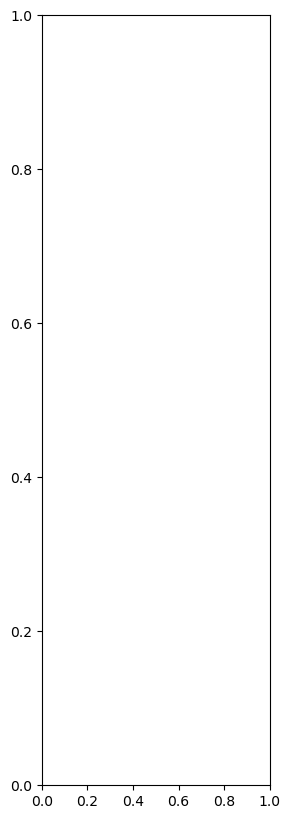

<Figure size 2000x1500 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [18]:
global_ds = xr.open_dataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/temp/GLOBAL_SAMI_REGRID_new.nc',
                               engine='h5netcdf')
# 10
orbits = [2,3,6,5,10,13,12,15] #list(range(2,10))#list(range(12))
path = '/home/pxv220016/scratch/multiorbit_data/' 


# Initialization of plots
a = 0
cmin = -0.5
cmax = 0.5
xmax = 80
xmin = -80
ymax = 25
ymin = 0

stitch_list = []

fig1 = plt.figure(figsize=(10,10))
specs = fig1.add_gridspec(4, 3, width_ratios=[1,1,1])
axes = []

fig_2 = plt.figure(figsize=(20,15))
specs_2 = fig_2.add_gridspec(8, 2, width_ratios=[1,1])
axes_2 = []

fig_d = plt.figure(figsize=(15,10))
specs_d = fig_d.add_gridspec(4,3,width_ratios=[1,1,1])
axes_d = []

fig_a = plt.figure(figsize=(15,10))
specs_a = fig_a.add_gridspec(4,3,width_ratios=[1,1,1])
axes_a = []


for orbit_num in tqdm(orbits):
    orbit_num = int(orbit_num)
    los_ds, df_grace, sami_time, lon_mean = los_tec(path, orbit_num)

    # obtaining VTEC from the global SAMI
    grace_est_tec = global_ds.sel(time=sami_time, 
                                  method='nearest').edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7
    
    # Obtaining dTEC after applying [40,85] minute bandpass filter
    del_tec = filters.make_fits(global_ds.edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7, percent=False).sel(time=sami_time, 
                                  method='nearest')
    
    # putting condition on the elevation angle
    elev_mask = df_grace.Elevation_Angle > 50 

    # Stiching STEC and smoothening STEC and VTEC
    stitched_ds, nature = calc_stec_vtec(df_grace, elev_mask, lat_lim=70)
    #print(len(stitched_ds.time.values))

    # Smoothening the curve
    stitched_ds = smooth_stec(stitched_ds)
    
    stitch_list.append(stitched_ds)

    '''
    # Why do smoothening if I am doing this in the next step?
    stec_sav2 = apply_savgol(stitched_ds.stec, 60, 1, diff=False)
    del_tec = filt_filt(stec_sav2)

    
    labels = [str(i.values)[11:16] for i in stitched_ds.time]
    row = a
    num_smooth = len(stitched_ds.time)
    xticks_num = int(num_smooth/10)
    label_loc = np.arange(0, num_smooth, xticks_num)
    label_name = []
    for i in range(len(labels)):
        if i%xticks_num == 0:
            label_name.append(labels[i])
    print(len(labels), len(label_loc), len(label_name))
            
    #print(labels[:5], label_name[:5])
    
    
    axes_2.append(fig_2.add_subplot(specs_2[row, 0]))
    axes_2[-1].plot(stitched_ds.time, stitched_ds.stec, label='STEC')
    axes_2[-1].set_title('STEC ' + nature + str(orbit_num))
    axes_2[-1].set_ylim(ymin, ymax)
    axes_2[-1].set_xticks(list(label_loc))
    axes_2[-1].set_xticklabels(label_name)
    axes_2[-1].legend()
    
    axes_2.append(fig_2.add_subplot(specs_2[row, 1]))
    axes_2[-1].plot(stitched_ds.time, del_tec, label='DTEC')
    axes_2[-1].set_title('dTEC ' + nature + str(orbit_num))
    #axes_2[-1].set_ylim(-0.5, 0.5)
    axes_2[-1].set_xticks(list(label_loc))
    axes_2[-1].set_xticklabels(label_name)
    axes_2[-1].legend()

    a+=1
    '''
    continue
    


    
    lats_smooth, stec_smooth = smooth_stec(stitched_ds, xmax)
    sav_1 = 50
    sav_2 = 90
    #stec_sav1 = apply_savgol(stec_smooth, 10, 2)
    stec_sav2 = apply_savgol(stec_smooth, sav_1, 1, diff=False)
    #stec_smooth_fin = filt_filt(stec_sav2, freq=1, lims=[5,400])
    #del_stec_smooth = [i-j for i,j in zip(stec_sav2, stec_smooth_fin)]
    del_stec_smooth = apply_savgol(stec_sav2, sav_2, 2, diff=True)
    stec_smooth_fin = apply_savgol(stec_sav2, sav_2, 2)
    

    # Plotting dTEC
    row = a//2
    col = a%2
    #print(row,col, a)

    # Plotting dTEC for all the ascending and descending passes
    axes.append(fig1.add_subplot(specs[row, col], projection=ccrs.PlateCarree()))
    c = del_tec.plot(x='lon', vmin = cmin, vmax = cmax, cmap='bwr', add_colorbar=False, ax=axes[-1])
    axes[-1].scatter(df_grace.Longitude[elev_mask], df_grace.Latitude[elev_mask])
    axes[-1].coastlines()
    axes[-1].add_feature(Nightshade(sami_time))
    axes[-1].gridlines(draw_labels=['bottom', 'left'], 
                       linestyle='--', color='k', alpha = 0.5)
    axes[-1].set_title(nature + 'DTEC at ' + str(sami_time)[11:19])
    
    if nature == ' desc ':
        # Plotting VTEC and stitched STEC
        axes_d.append(fig_d.add_subplot(specs[row, 0]))
        #axes_d[-1].scatter(stitched_ds.lats, stitched_ds.vtec, label='Smooth VTEC')
        axes_d[-1].plot(grace_est_tec.sel(lon=lon_mean, method='nearest').lat, grace_est_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_d[-1].scatter(stitched_ds.lats, stitched_ds.stec, label='Smooth STEC')
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_ylim(ymin, ymax)
        axes_d[-1].set_title(str(sami_time)[10:19])
        axes_d[-1].legend()

        axes_d.append(fig_d.add_subplot(specs[row, 1]))
        #axes_d[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_d[-1].plot(lats_smooth, stec_smooth_fin, label='Filter2 Smooth STEC')
        axes_d[-1].plot(lats_smooth, stec_sav2 + 5, label='Filter1 Smooth STEC')
        axes_d[-1].scatter(stitched_ds.lats, stitched_ds.stec + 10, label='Stitched STEC')
        axes_d[-1].set_ylim(ymin, ymax)
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_title('Savgol Fit Comparison, Sav = ' + str(sav_1) + ' ord= 2')
        axes_d[-1].legend()
        
        axes_d.append(fig_d.add_subplot(specs[row, 2]))
        #axes_d[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_d[-1].plot(del_tec.sel(lon=lon_mean, method='nearest').lat, del_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_d[-1].scatter(lats_smooth, del_stec_smooth, label='Smooth STEC')
        axes_d[-1].set_ylim(-0.5, 0.5)
        axes_d[-1].set_xlim(xmin, xmax)
        axes_d[-1].set_title('dTEC ' + str(sav_2) + 'ord= 2')
        axes_d[-1].legend()
        
    else:
        # Plotting VTEC and stitched STEC
        axes_a.append(fig_a.add_subplot(specs[row, 0]))
        #axes_a[-1].scatter(stitched_ds.lats, stitched_ds.vtec, label='Smooth VTEC')
        axes_a[-1].plot(grace_est_tec.sel(lon=lon_mean, method='nearest').lat, grace_est_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_a[-1].scatter(stitched_ds.lats, stitched_ds.stec, label='Smooth STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(ymin, ymax)
        axes_a[-1].set_title(str(sami_time)[10:19])
        axes_a[-1].legend()
        
        axes_a.append(fig_a.add_subplot(specs[row, 1]))
        #axes_a[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_a[-1].plot(lats_smooth, stec_smooth_fin, label='Filter2 Smooth STEC')
        axes_a[-1].plot(lats_smooth, stec_sav2 + 5, label='Filter1 Smooth STEC')
        axes_a[-1].scatter(stitched_ds.lats, stitched_ds.stec + 10, label='Stitched STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(ymin, ymax)
        axes_a[-1].set_title('Savgol Fit Comparison, Sav = ' + str(sav_1) + ' ord= 2')
        axes_a[-1].legend()

        axes_a.append(fig_a.add_subplot(specs[row, 2]))
        #axes_a[-1].scatter(lats_smooth, vtec_smooth, label='Smooth VTEC')
        axes_a[-1].plot(del_tec.sel(lon=lon_mean, method='nearest').lat, del_tec.sel(lon=lon_mean, method='nearest'), color='red', label='VTEC')
        axes_a[-1].scatter(lats_smooth, del_stec_smooth, label='Smooth STEC')
        axes_a[-1].set_xlim(xmin, xmax)
        axes_a[-1].set_ylim(-0.5, 0.5)
        axes_a[-1].set_title('dTEC ' + str(sav_2) + 'ord= 2')
        axes_a[-1].legend()
    

    
    a += 1

    
    # ------PLOTTING---------
    '''
    # Plotting satellite passes (with each gps satellite shown) on 
    # global map with VTEC in background

    n = int(len(df_grace.LT)/2)
    prn = df_grace.PRN[elev_mask].unique()
    shape = ['o', 's', '^', 'v', 'x', '+', '*', 'D']
        
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    grace_est_tec.plot(x='lon',cbar_kwargs={'label':'VTEC'})
    ax.coastlines()
    ax.add_feature(Nightshade(sami_time), alpha=0.3)
    
    ax.set_title('LT = ' + str(df_grace.LT[n])[:5] + ', UT = ' + str(df_grace.date[n]) + nature)
    
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        ecef_geodetic = il.reload(ecef_geodetic)
        lat, lon, _ = ecef_geodetic.ecef_to_lla(df_g1.GPS_Position_X[0],df_g1.GPS_Position_Y[0],df_g1.GPS_Position_Z[0])
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(lon, lat, marker = s, c='w')
        # each sub-intervals for different prn is offset by 5 longitudes to prevent overlapping
        plt.scatter(df_g1.Longitude[elev_mask1] + 5*i, df_g1.Latitude[elev_mask1], c=df_g1.tecs[elev_mask1], vmin = min(df_grace.tecs[elev_mask]), vmax = max(df_grace.tecs[elev_mask]), marker = s, transform=ccrs.PlateCarree(), label = p)     
    plt.legend()
    plt.colorbar();
    #plt.show()
    '''
    
    
    '''
    # Plotting STEC for each PRN (colorbar showing elevation angle)
    # and VTEC against Latitude
    
    plt.figure(figsize=(12,8))
    for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
        
        df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
        elev_mask1 = df_g1.Elevation_Angle > 50
        
        plt.scatter(df_g1.Latitude[elev_mask1], df_g1.tecs[elev_mask1], c=df_g1.Elevation_Angle[elev_mask1], vmin = min(df_grace.Elevation_Angle[elev_mask]), vmax=max(df_grace.Elevation_Angle[elev_mask]), marker =s, label = p)
    
    grace_est_tec.sel(lon=lon_mean, method='nearest').plot(color='red')
    plt.legend()
    plt.colorbar();
    #plt.show()
    '''


    '''
    # Plotting Smoothened STEC and VTEC (using spline first and savgol)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))    
    axs[0].scatter(stitched_ds.lats,stitched_ds.vtec, label='Stiched VTECs')
    axs[0].scatter(stitched_ds.lats,stitched_ds.stec, label='Stitched STECs')
    grace_est_tec.sel(lon=lon_mean, method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_title('Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stitched_ds.stec, stitched_ds.vtec)]
    axs[1].set_title('Difference Between Stitched STEC and VTEC')
    axs[1].scatter(stitched_ds.lats, del_t)
    axs[1].set_ylim(bottom = 0, top = 4)
    #plt.show()
    '''
    
    '''
    # Plotting Error Between Smoothened STEC and VTECs
    
    stec_smooth_err = [100*(j-i)/i for i,j in zip(stitched_ds.stec, stec_smooth)]
    vtec_smooth_err = [100*(j-i)/i for i,j in zip(stitched_ds.vtec, vtec_smooth)]
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))    
    axs[0].plot(latitudes,vtec_smooth, label='Stiched VTECs')
    axs[0].plot(latitudes,stec_smooth, label='Stitched STECs')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(ax=axs[0], color='red', label='Global SAMI VTEC')
    axs[0].legend()
    axs[0].set_xlim(left = -90, right = 90)
    axs[0].set_title('Smoothened Stitched TECs vs VTEC from Global SAMI')
    del_t = [i-j for i,j in zip(stec_smooth, vtec_smooth)]
    axs[1].set_title('Error Due to Smoothening of Stitched STEC and VTEC')
    axs[1].scatter(latitudes, vtec_smooth_err, label='% VTEC error')
    axs[1].scatter(latitudes, stec_smooth_err, label='% STEC error')
    axs[1].set_ylim(bottom = -10, top = 10)
    axs[1].set_xlim(left = -90, right = 90)
    plt.show()
    '''


fig_2.suptitle('Time Interpolated Stitched STEC Plots', fontweight='heavy', fontsize='x-large')
fig_2.tight_layout()
fig_2.subplots_adjust(hspace=1)
fig_2.show();


path = '/home/pxv220016/scratch/multiorbit_data/stitched_stec/'
for s, o in zip(stitch_list, orbits):
    s.to_netcdf(path + str(o) + '.nc')

# Create colorbar axes and draw it
cbar_ax = fig1.add_subplot(specs[:,-1])
# Draw colorbar with cax, not ax, to tell matplotlib to use the whole axes
cbar = fig1.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig1.suptitle('TEC Above 500km and Different Sami_time', fontweight='heavy', fontsize='x-large')
fig1.tight_layout()
fig1.show();

fig_d.suptitle('Descending Pass Stitched STEC and VTEC', fontweight='heavy', fontsize='x-large')
fig_d.tight_layout()
fig_d.show();

fig_a.suptitle('Ascending Pass Stitched STEC and VTEC', fontweight='heavy', fontsize='x-large')
fig_a.tight_layout()
fig_a.show();


In [9]:
stitched_list = []
path = '/home/pxv220016/scratch/multiorbit_data/stitched_stec/'
orbits = [2,3,6,5,10,13,12,15]
for o in orbits:
    f_path = path + str(o) + '.nc'
    new = xr.open_dataset(f_path)
    stitched_list.append(new)

In [41]:
int((stitched_ds.time.values[0])[11:13])

12

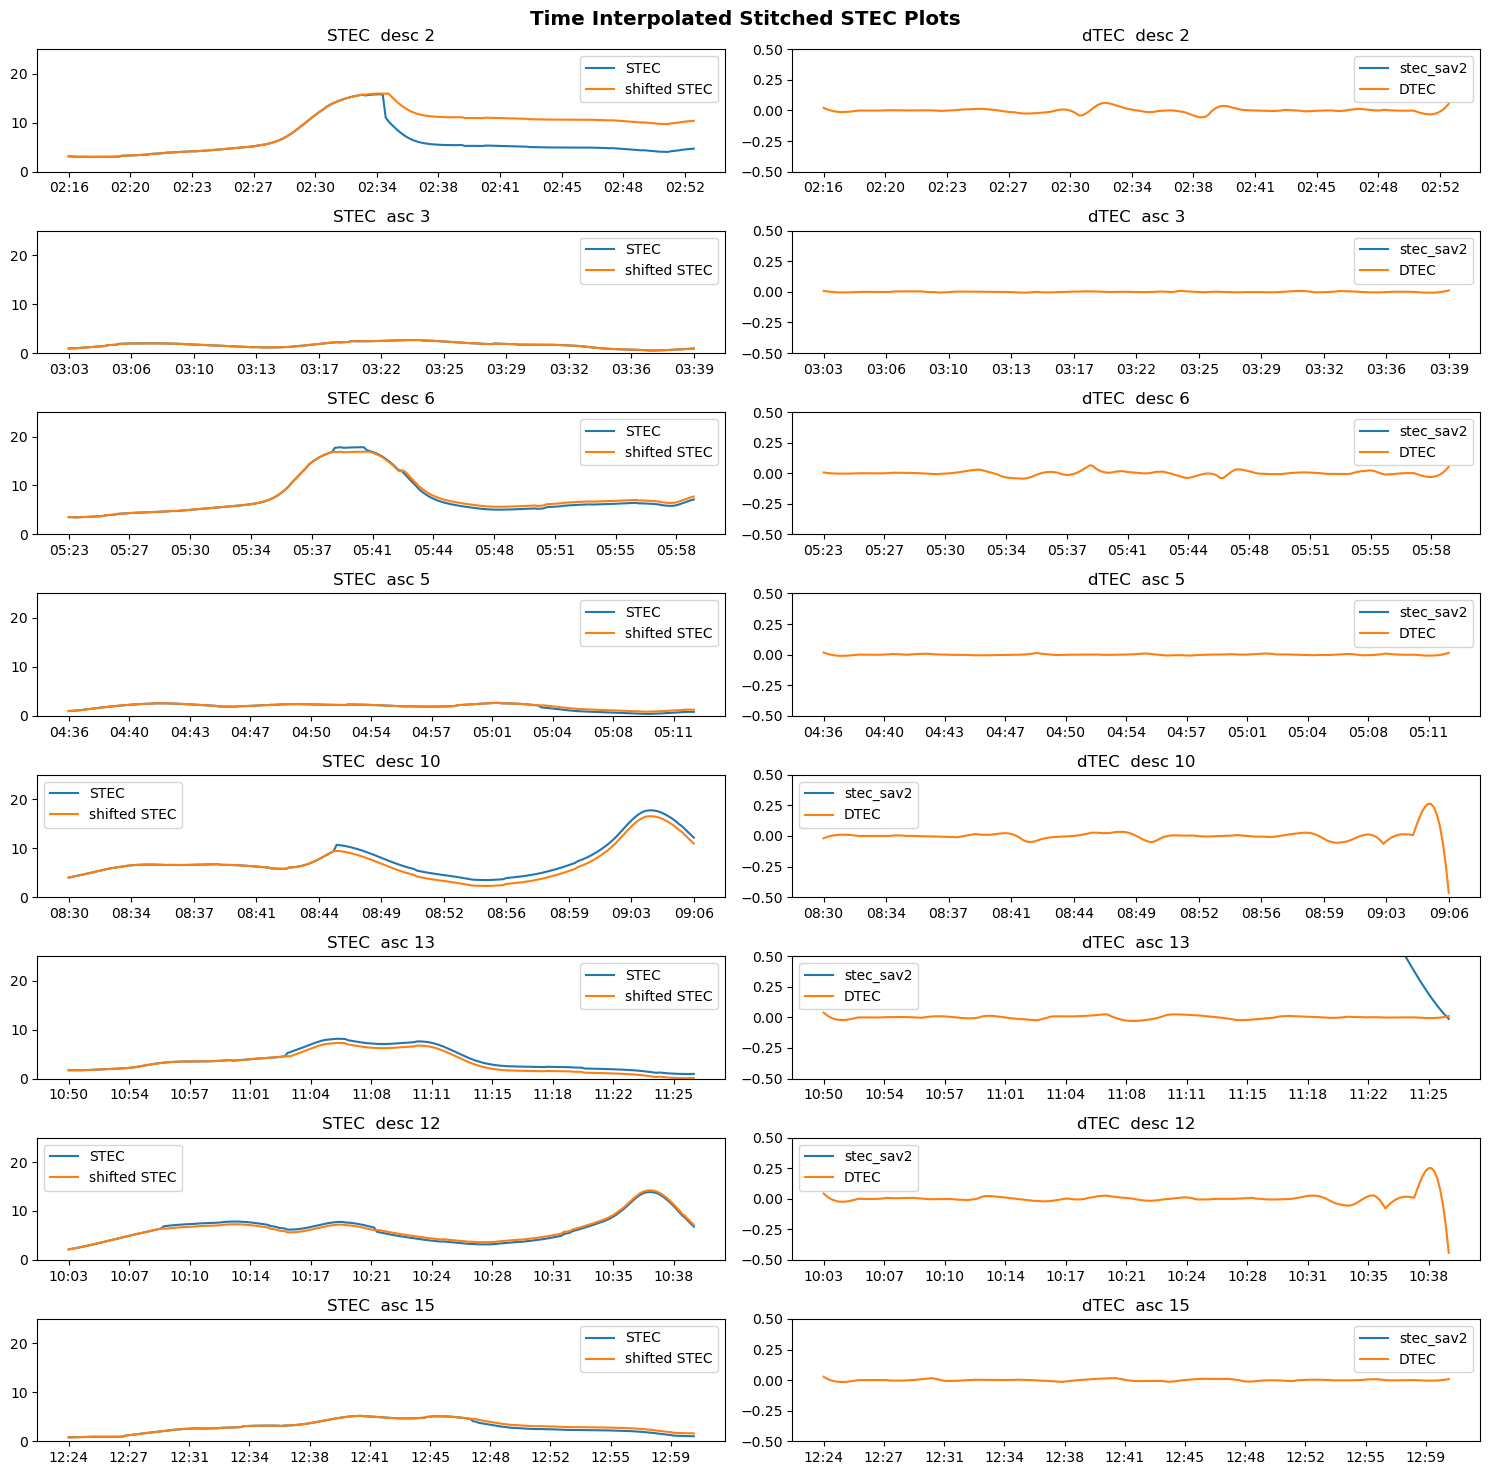

In [18]:

fig_2 = plt.figure(figsize=(15,15))
specs_2 = fig_2.add_gridspec(8, 2, width_ratios=[1,1])
axes_2 = []
a=0
ymax = 25
ymin = 0

first = []
second = []

for stitched_ds, orbit_num in zip(stitched_list, orbits):

    nature = ' asc '
    if stitched_ds.lats[0] > stitched_ds.lats[10]:
        nature = ' desc '

    diff = []
    for i in range(len(stitched_ds.stec)-1):
        diff.append(stitched_ds.stec.values[i] - stitched_ds.stec.values[i+1])
    diff.append(0)
    
    new_diff = []
    new_diff.append(0)
    for i in range(len(stitched_ds.stec)-1):
        new_diff.append(diff[i] - diff[i+1])
    new_diff.append(0)

    
    # Removing the gaps created while stitching STEC
    shift = 0
    stitch_smooth_tec = []
    for i in range(len(stitched_ds.stec)-1):
        stitch_smooth_tec.append(stitched_ds.stec[i] - shift)
        if abs(new_diff[i]) > 0.25:
            shift += stitched_ds.stec[i+1] - stitched_ds.stec[i]
    stitch_smooth_tec.append(stitched_ds.stec[-1] - shift)        
    
    

    # Why do smoothening if I am doing this in the next step?
    stec_sav2 = apply_savgol(stitch_smooth_tec, 45, 3, diff=False)
    #del_tec = filters.make_fits(stec_sav2, freq=10, lims=[m, n]) # [40*60/4, 40*60/3]
    del_tec = apply_savgol(stec_sav2, 25, 2, diff=True)

    if nature == ' asc ':
        if int((stitched_ds.time.values[0])[11:13]) < 6:
            if np.max(del_tec) > 0.1 or abs(np.min(del_tec)) > 0.1:
                fit = False
                break
        else:
            if np.max(del_tec) > 0.2 or abs(np.min(del_tec)) > 0.2:
                fit = False
                break
    else:
        if int((stitched_ds.time.values[0])[11:13]) < 6:
            if np.max(del_tec) > 0.1 or abs(np.min(del_tec)) > 0.1:
                fit = False
                break
        else:
            if np.max(del_tec) < 0.2 or abs(np.min(del_tec)) < 0.2:
                fit = False      
                break

    
    labels = [str(i.values)[11:16] for i in stitched_ds.time]
    row = a
    num_smooth = len(stitched_ds.time)
    xticks_num = int(num_smooth/10)
    label_loc = np.arange(0, num_smooth, xticks_num)
    label_name = []
    for i in range(len(labels)):
        if i%xticks_num == 0:
            label_name.append(labels[i])            
    #print(labels[:5], label_name[:5])
    
    axes_2.append(fig_2.add_subplot(specs_2[row, 0]))
    axes_2[-1].plot(stitched_ds.time, stitched_ds.stec, label='STEC')
    axes_2[-1].plot(stitched_ds.time, stitch_smooth_tec, label='shifted STEC')
    axes_2[-1].set_title('STEC ' + nature + str(orbit_num))
    axes_2[-1].set_ylim(ymin, ymax)
    axes_2[-1].set_xticks(list(label_loc))
    axes_2[-1].set_xticklabels(label_name)
    axes_2[-1].legend()

    axes_2.append(fig_2.add_subplot(specs_2[row, 1]))
    axes_2[-1].plot(stitched_ds.time, stec_sav2, label='stec_sav2')
    axes_2[-1].plot(stitched_ds.time, del_tec, label='DTEC')
    axes_2[-1].set_title('dTEC ' + nature + str(orbit_num))
    axes_2[-1].set_ylim(-0.5, 0.5)
    axes_2[-1].set_xticks(list(label_loc))
    axes_2[-1].set_xticklabels(label_name)
    axes_2[-1].legend()

    a+=1
    
    

fig_2.suptitle('Time Interpolated Stitched STEC Plots', fontweight='heavy', fontsize='x-large')
fig_2.tight_layout()
#fig_2.subplots_adjust(hspace=1)
fig_2.show();


In [147]:
stitched_ds

<xarray.Dataset> Size: 59kB
Dimensions:  (ind: 219, time_s: 2180)
Coordinates:
  * ind      (ind) int64 2kB 0 1 2 3 4 5 6 7 ... 211 212 213 214 215 216 217 218
  * time_s   (time_s) datetime64[ns] 17kB 2013-03-17T12:24:09 ... 2013-03-17T...
Data variables:
    time     (ind) <U19 17kB '2013-03-17 12:24:09' ... '2013-03-17 13:00:29'
    lats     (ind) float64 2kB -69.8 -69.16 -68.52 -67.89 ... 68.58 69.23 69.87
    stec     (ind) float64 2kB 0.7893 0.8077 0.826 0.844 ... 1.055 1.04 1.024
    vtec     (ind) float64 2kB 0.7392 0.7606 0.782 ... 0.8838 0.8668 0.8484
    stec_s   (time_s) float64 17kB 0.7893 0.7912 0.793 ... 1.029 1.027 1.026

In [67]:
print(grace_est_tec.sel(lon=lon_mean, method='nearest'))

<xarray.DataArray 'edens' (lat: 180)> Size: 1kB
array([ 4.91028108,  5.04572098,  5.14399379,  5.23247989,  5.34586674,
        5.41653363,  5.46688909,  5.51295376,  5.54151835,  5.55181463,
        5.590137  ,  5.68568842,  5.79122869,  5.88636052,  5.95606792,
        5.98561098,  5.97999493,  5.94972568,  5.90682973,  5.82659581,
        5.71670177,  5.6202618 ,  5.52137698,  5.33833699,  5.1945026 ,
        5.0237096 ,  4.78755644,  4.59692779,  4.66766899,  4.86631192,
        5.03595641,  5.10509101,  5.18569751,  5.2724439 ,  5.36562837,
        5.47424569,  5.57705777,  5.68715139,  5.78637421,  5.8597049 ,
        5.91977875,  5.9704671 ,  6.00784027,  6.0291074 ,  6.03479911,
        6.04100916,  6.03524507,  6.03842108,  6.03414756,  6.03924701,
        6.01875021,  6.02507477,  6.01939432,  6.03933261,  6.04508464,
        6.07826318,  6.08998272,  6.11684295,  6.1452234 ,  6.16515477,
        6.19283179,  6.21457109,  6.23882274,  6.27727209,  6.29991881,
        6.325632

In [40]:

print(grace_est_tec.lon)


<xarray.DataArray 'lon' (lon: 90)> Size: 720B
array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
        56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108,
       112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164,
       168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220,
       224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276,
       280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332,
       336, 340, 344, 348, 352, 356])
Coordinates:
    time     datetime64[ns] 8B 2013-03-17T05:40:00
  * lon      (lon) int64 720B 0 4 8 12 16 20 24 ... 332 336 340 344 348 352 356


In [4]:
los_ds

<xarray.Dataset> Size: 416MB
Dimensions:    (sat_pt: 1736, alt_lev: 50, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
  * sat_pt     (sat_pt) int64 14kB 0 1 2 3 4 5 ... 1730 1731 1732 1733 1734 1735
  * alt_lev    (alt_lev) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    lat        (sat_pt, alt_lev) float64 694kB -89.12 -89.02 ... 46.41 45.4
    lon        (sat_pt, alt_lev) float64 694kB 28.83 23.47 ... -145.3 -145.3
    alt        (sat_pt, alt_lev) float64 694kB 606.4 619.8 ... 2.019e+04
    edens      (sami_time, sat_pt, alt_lev) float64 414MB 7.609e+04 ... 0.0

In [4]:
global_ds

NameError: name 'global_ds' is not defined

In [ ]:
print(len(df_grace.tecs[elev_mask]), len(df_grace.Latitude[elev_mask].unique()))

    lats = df_grace.Latitude[elev_mask].unique()
    
    stec = []
    for l in lats:
        df_lat = (df_grace.iloc[np.where(df_grace.Latitude == l)].reset_index(drop = True))
        numer = 0
        denom = 0
        for st, el in zip(df_lat.tecs, df_lat.Elevation_Angle):
            if el > 50:
                numer += st*el
                denom += el    
        stec.append(numer/denom)
    
    plt.figure(figsize=(12,8))
    plt.scatter(lats,stec, label='Stiched STEC')
    grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red', label='GlobalVTEC')
    plt.legend()
    plt.show()

In [21]:
import math

print(np.cos(np.radians(60)))

0.5000000000000001


In [ ]:
los_ds = xr.open_mfdataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316/edens_SAMI-REGRID.nc')
                           #engine='h5netcdf')